##  <20 lines of code to slice out 100k experiments and their SNP near BRAF V600 in seconds

In [1]:
### parameters
import pandas as pd
import numpy as np
mySpecie='Homo_sapiens'
"""
Download from synapse if it is not installed
"""
skymap_snp_dir='/cellar/users/btsui/Data/SRA/snp/{specie}_snp_pos/'.format(specie=mySpecie)

In [2]:
#!ls /cellar/users/btsui/Data/SRA/snp/Homo_sapiens_snp_pos/

### BRAF V600 coordinate 

In [3]:
#location where BRAF V600 happens, you can change it to whatever position you want 
#http://cancer.sanger.ac.uk/cosmic/mutation/overview?id=476
queryChr,queryPosition='7',140753336 

In [4]:
window=15
readThreshold=5

static code for slicing out the data

In [5]:
#str(myChunk)

In [6]:
%%time
chunkSize=100000 #fixed params
myChunk=int(queryPosition/chunkSize)*chunkSize
print (myChunk)
hdf_s=pd.HDFStore(skymap_snp_dir+'Pos_block_'+str(myChunk),mode='r')
tmpChunkDf=hdf_s['/chunk']
myPosDf=tmpChunkDf[(tmpChunkDf.Pos>=(queryPosition-window))&(tmpChunkDf.Pos<=(queryPosition+window))].reset_index()
m1=myPosDf[b'Chr']==queryChr
m2=myPosDf['ReadDepth']>=readThreshold
myChrPosDf=myPosDf[m1&m2]

140700000
CPU times: user 5.11 s, sys: 728 ms, total: 5.84 s
Wall time: 2.72 s


In [7]:
#tmpChunkDf

In [8]:
#myPosDf

In [9]:
print ('# of studies sliced out:' ,tmpChunkDf.Run_digits.nunique())

# of studies sliced out: 149064


### the slice out the window at around BRAF V600

In [10]:
myChrPosDf.head()

b'features' b'Chr' b'base' b'Run_db'  Run_digits        Pos  ReadDepth  \
2                7       C       SRR     1177675  140753321          9   
3                7       C       SRR     4444531  140753321          5   
6                7       C       SRR     5882370  140753321         39   
9                7       C       SRR     5111728  140753321          5   
17               7       C       SRR     2125816  140753321          5   

b'features'  AverageBaseQuality      block  
2                            39  140700000  
3                            40  140700000  
6                            39  140700000  
9                            39  140700000  
17                           37  140700000

#### meaning of each column
Chr: Chromosome

Base: DNA bases in aligned reads - A, C, G, T 

Run_db and Run_digits together forms a SRR accession id. I ignored the leading 0s for Run_digits. 

ReadDepth: the number of bases detected in aligned reads at a particular base and chromosome position. 

AverageBaseQuality: The mean phred score in aligned reads at a particular base and chromosome postiion. 

Pos: Chromosome position. (grch38 for human)

block: the block ID used for chunked storage

# The above 20 lines are basically all you need to know
to identify hundred thousands of sequencing runs with reads near your query postion. 

Keep reading if you are interested in some examples of basic analysis. 


###### find reference base for each chrosome coordinate

In [11]:
###it's a 
"""
The original vcf file can be downloaded from: ftp://ftp.ncbi.nih.gov/snp/organisms/human_9606/VCF/All_20170710.vcf.gz
I ignored all the entries without any phentoype related resources to suppport, where the byte2 of the VCF equals to zero.
For more info: ftp://ftp.ncbi.nlm.nih.gov/snp/specs/dbSNP_BitField_latest.pdf
"""
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(np.str)
my_chrom_vcfDf=vcfDf[(vcfDf['Chr']==queryChr)]
posToRefBase=my_chrom_vcfDf.set_index('Pos')['RefBase']
posToRefBase=posToRefBase.str[0]
posToRefBase=posToRefBase.groupby(posToRefBase.index).first()


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### visualize the landscape of BRAFV600 mutated samples

Since human sequencing data are mostly generated from cell lines, we expect the cells measured often come with a highly  specifc oncogeneic transformation, thus we should observe a overpresenation of data with BRAFV600 as compared to its immediate neighboring regions, as shown in the following figure.

In [12]:
myChrPosDf.head()

b'features' b'Chr' b'base' b'Run_db'  Run_digits        Pos  ReadDepth  \
2                7       C       SRR     1177675  140753321          9   
3                7       C       SRR     4444531  140753321          5   
6                7       C       SRR     5882370  140753321         39   
9                7       C       SRR     5111728  140753321          5   
17               7       C       SRR     2125816  140753321          5   

b'features'  AverageBaseQuality      block  
2                            39  140700000  
3                            40  140700000  
6                            39  140700000  
9                            39  140700000  
17                           37  140700000

In [13]:
sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

In [14]:
technical_meta_data_df['Run']=technical_meta_data_df.index

technical_meta_data_df=technical_meta_data_df.set_index(['Run_db','Run_digits'])#.index.isin(altBaseDf.index)

In [15]:
query_study_id='SRP067759'
hitSrrDf=technical_meta_data_df[technical_meta_data_df.Study==query_study_id]

In [16]:
hitSrrDf.head()

Member_Name  Experiment      Sample      Study      Spots  \
Run_db Run_digits                                                             
SRR    3052037        default  SRX1500380  SRS1223069  SRP067759   935534.0   
       3052038        default  SRX1500381  SRS1223065  SRP067759   582953.0   
       3052039        default  SRX1500382  SRS1223064  SRP067759  1893162.0   
       3052040        default  SRX1500383  SRS1223063  SRP067759  2513458.0   
       3052041        default  SRX1500384  SRS1223068  SRP067759   953109.0   

                         Bases Status ScientificName LibraryStrategy  \
Run_db Run_digits                                                      
SRR    3052037      47712234.0   live   Homo_sapiens         RNA-Seq   
       3052038      29730603.0   live   Homo_sapiens         RNA-Seq   
       3052039      96551262.0   live   Homo_sapiens         RNA-Seq   
       3052040     128186358.0   live   Homo_sapiens         RNA-Seq   
       3052041      48608559.0   live   Homo_sapiens         RNA-Seq   

                  LibraryLayout     ...     proj_accession_Updated  \
Run_db Run_digits                   ...                              
SRR    3052037           SINGLE     ...                 2017-05-15   
       3052038           SINGLE     ...                 2017-05-15   
       3052039           SINGLE     ...                 2017-05-15   
       3052040           SINGLE     ...                 2017-05-15   
       3052041           SINGLE     ...                 2017-05-15   

                  proj_accession_Published proj_accession_Received  \
Run_db Run_digits                                                    
SRR    3052037                  2017-05-15              2015-12-23   
       3052038                  2017-05-15              2015-12-23   
       3052039                  2017-05-15              2015-12-23   
       3052040                  2017-05-15              2015-12-23   
       3052041                  2017-05-15              2015-12-23   

                  proj_accession_Type proj_accession_Center  \
Run_db Run_digits                                             
SRR    3052037                    RUN                   GEO   
       3052038                    RUN                   GEO   
       3052039                    RUN                   GEO   
       3052040                    RUN                   GEO   
       3052041                    RUN                   GEO   

                  proj_accession_Visibility proj_accession_Loaded  \
Run_db Run_digits                                                   
SRR    3052037                       public                     1   
       3052038                       public                     1   
       3052039                       public                     1   
       3052040                       public                     1   
       3052041                       public                     1   

                  proj_accession_ReplacedBy new_ScientificName         Run  
Run_db Run_digits                                                           
SRR    3052037                            -       Homo_sapiens  SRR3052037  
       3052038                            -       Homo_sapiens  SRR3052038  
       3052039                            -       Homo_sapiens  SRR3052039  
       3052040                            -       Homo_sapiens  SRR3052040  
       3052041                            -       Homo_sapiens  SRR3052041  

[5 rows x 22 columns]

In [17]:
myChrPosDfI=myChrPosDf.set_index([b'Run_db','Run_digits']).index

In [18]:
hitSrrDf.head()

Member_Name  Experiment      Sample      Study      Spots  \
Run_db Run_digits                                                             
SRR    3052037        default  SRX1500380  SRS1223069  SRP067759   935534.0   
       3052038        default  SRX1500381  SRS1223065  SRP067759   582953.0   
       3052039        default  SRX1500382  SRS1223064  SRP067759  1893162.0   
       3052040        default  SRX1500383  SRS1223063  SRP067759  2513458.0   
       3052041        default  SRX1500384  SRS1223068  SRP067759   953109.0   

                         Bases Status ScientificName LibraryStrategy  \
Run_db Run_digits                                                      
SRR    3052037      47712234.0   live   Homo_sapiens         RNA-Seq   
       3052038      29730603.0   live   Homo_sapiens         RNA-Seq   
       3052039      96551262.0   live   Homo_sapiens         RNA-Seq   
       3052040     128186358.0   live   Homo_sapiens         RNA-Seq   
       3052041      48608559.0   live   Homo_sapiens         RNA-Seq   

                  LibraryLayout     ...     proj_accession_Updated  \
Run_db Run_digits                   ...                              
SRR    3052037           SINGLE     ...                 2017-05-15   
       3052038           SINGLE     ...                 2017-05-15   
       3052039           SINGLE     ...                 2017-05-15   
       3052040           SINGLE     ...                 2017-05-15   
       3052041           SINGLE     ...                 2017-05-15   

                  proj_accession_Published proj_accession_Received  \
Run_db Run_digits                                                    
SRR    3052037                  2017-05-15              2015-12-23   
       3052038                  2017-05-15              2015-12-23   
       3052039                  2017-05-15              2015-12-23   
       3052040                  2017-05-15              2015-12-23   
       3052041                  2017-05-15              2015-12-23   

                  proj_accession_Type proj_accession_Center  \
Run_db Run_digits                                             
SRR    3052037                    RUN                   GEO   
       3052038                    RUN                   GEO   
       3052039                    RUN                   GEO   
       3052040                    RUN                   GEO   
       3052041                    RUN                   GEO   

                  proj_accession_Visibility proj_accession_Loaded  \
Run_db Run_digits                                                   
SRR    3052037                       public                     1   
       3052038                       public                     1   
       3052039                       public                     1   
       3052040                       public                     1   
       3052041                       public                     1   

                  proj_accession_ReplacedBy new_ScientificName         Run  
Run_db Run_digits                                                           
SRR    3052037                            -       Homo_sapiens  SRR3052037  
       3052038                            -       Homo_sapiens  SRR3052038  
       3052039                            -       Homo_sapiens  SRR3052039  
       3052040                            -       Homo_sapiens  SRR3052040  
       3052041                            -       Homo_sapiens  SRR3052041  

[5 rows x 22 columns]

In [19]:
m_project=myChrPosDfI.isin(hitSrrDf.index)

In [20]:

### recover reference base
myChrPosDf['RefBase']=posToRefBase.loc[myChrPosDf['Pos']].values
### is base alt?
myChrPosDf['AltBase']=myChrPosDf['RefBase']!=myChrPosDf[b'base']
#### consider dropping duplciates of Runs (a runs can have multiple bases) 
myPosCountDf=myChrPosDf[m_project].groupby(['Pos','AltBase']).size()


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [21]:
myChrPosDf.head()

b'features' b'Chr' b'base' b'Run_db'  Run_digits        Pos  ReadDepth  \
2                7       C       SRR     1177675  140753321          9   
3                7       C       SRR     4444531  140753321          5   
6                7       C       SRR     5882370  140753321         39   
9                7       C       SRR     5111728  140753321          5   
17               7       C       SRR     2125816  140753321          5   

b'features'  AverageBaseQuality      block RefBase  AltBase  
2                            39  140700000       C    False  
3                            40  140700000       C    False  
6                            39  140700000       C    False  
9                            39  140700000       C    False  
17                           37  140700000       C    False

In [22]:

### mutations, in BRAF mutations
#myChrPosDf

In [23]:
inDf=myPosCountDf.unstack()
fractionDf=(inDf.T/inDf.sum(axis=1)).T

[]

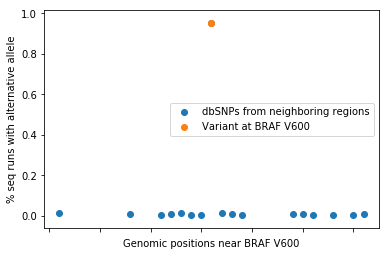

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.scatter(x=fractionDf.index,y=fractionDf[True],label='dbSNPs from neighboring regions')
queryDf=fractionDf[fractionDf.index==queryPosition]
ax.scatter(x=[queryPosition],y=fractionDf.loc[[queryPosition]][True],label='Variant at BRAF V600')
ax.set_ylabel('% seq runs with alternative allele')
ax.set_xlabel('Genomic positions near BRAF V600')
ax.legend()
ax.set_xticklabels([])

In [82]:
myChrPosDf_hit=myChrPosDf[(myChrPosDf.Pos==queryPosition)&m_project]

In [83]:
technical_meta_data_df.head()

Member_Name  Experiment      Sample Study   Spots  \
Run_db Run_digits                                                     
SRR    2401865        default  SRX1244330  SRS1068422     -  2800.0   
       2401866        default  SRX1244331  SRS1068421     -  5082.0   
       2401867        default  SRX1244332  SRS1068420     -  6169.0   
       2401868        default  SRX1244333  SRS1068419     -  8102.0   
       2401869        default  SRX1244334  SRS1068418     -  4971.0   

                       Bases Status   ScientificName LibraryStrategy  \
Run_db Run_digits                                                      
SRR    2401865     1416405.0   live  soil_metagenome        AMPLICON   
       2401866     2563605.0   live  soil_metagenome        AMPLICON   
       2401867     3175528.0   live  soil_metagenome        AMPLICON   
       2401868     4266915.0   live  soil_metagenome        AMPLICON   
       2401869     2519200.0   live  soil_metagenome        AMPLICON   

                  LibraryLayout     ...     proj_accession_Updated  \
Run_db Run_digits                   ...                              
SRR    2401865           SINGLE     ...                 2015-09-22   
       2401866           SINGLE     ...                 2015-09-22   
       2401867           SINGLE     ...                 2015-09-22   
       2401868           SINGLE     ...                 2015-09-22   
       2401869           SINGLE     ...                 2015-09-22   

                  proj_accession_Published proj_accession_Received  \
Run_db Run_digits                                                    
SRR    2401865                  2015-09-20              2015-09-15   
       2401866                  2015-09-20              2015-09-15   
       2401867                  2015-09-20              2015-09-15   
       2401868                  2015-09-20              2015-09-15   
       2401869                  2015-09-20              2015-09-15   

                  proj_accession_Type proj_accession_Center  \
Run_db Run_digits                                             
SRR    2401865                    RUN            SUB1095135   
       2401866                    RUN            SUB1095135   
       2401867                    RUN            SUB1095135   
       2401868                    RUN            SUB1095135   
       2401869                    RUN            SUB1095135   

                  proj_accession_Visibility proj_accession_Loaded  \
Run_db Run_digits                                                   
SRR    2401865                       public                     1   
       2401866                       public                     1   
       2401867                       public                     1   
       2401868                       public                     1   
       2401869                       public                     1   

                  proj_accession_ReplacedBy new_ScientificName         Run  
Run_db Run_digits                                                           
SRR    2401865                            -    soil_metagenome  SRR2401865  
       2401866                            -    soil_metagenome  SRR2401866  
       2401867                            -    soil_metagenome  SRR2401867  
       2401868                            -    soil_metagenome  SRR2401868  
       2401869                            -    soil_metagenome  SRR2401869  

[5 rows x 22 columns]

In [84]:
I=myChrPosDf_hit.set_index([b'Run_db','Run_digits']).index

In [85]:
myChrPosDf_hit['Run']=technical_meta_data_df.loc[I]['Run'].values

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [168]:
multI=myChrPosDf_hit.set_index([b'Run_db','Run_digits']).index

In [170]:
myChrPosDf_hit['Sample']=technical_meta_data_df['Sample'].loc[multI].values

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [174]:
#myChrPosDf_hit

In [138]:
metaDataMappingSDir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'
bio_metaDf=pd.read_pickle(metaDataMappingSDir)

array(['SRS1223069', 'SRS1223065', 'SRS1223064', ..., 'SRS2015360',
       'SRS2015358', 'SRS2015361'], dtype=object)

In [153]:
bio_metaDf_hit=bio_metaDf.loc[hitSrrDf['Sample'].unique()]

In [158]:
srsToStage=bio_metaDf_hit.groupby(level=[1,0]).first().loc['tumor stage']

In [175]:
myChrPosDf_hit['tumor stage']=srsToStage.loc[myChrPosDf_hit.Sample].values

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [179]:
#TKI
myChrPosDf_hit['tumor stage'].value_counts().index

Index(['3_months_TKI', 'diagnosis', 'blast_crisis', '6_months_TKI',
       'pre_blast_crisis', 'blast_crisis_1_month_TKI', 'Cell line',
       'normal_hsc', '1_year_TKI', '5_years_TKI', '18_months_TKI'],
      dtype='object')

TKI stands for: tyrosine kinase inhibitor

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

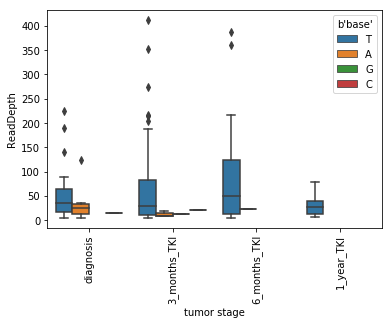

In [203]:
m=myChrPosDf_hit['AverageBaseQuality']>=30
sns.boxplot(data=myChrPosDf_hit[m],x='tumor stage',hue=b'base',y='ReadDepth',
        order=['diagnosis','3_months_TKI','6_months_TKI', '1_year_TKI'])
plt.xticks(rotation=90)


### identify expression data

In [86]:

def loadDf(fname,mmap_mode='r'):
    with open(fname+'.index.txt') as f:
        myIndex=map(lambda s:s.replace("\n",""), f.readlines())
    with open(fname+'.columns.txt') as f:
        myColumns=map(lambda s:s.replace("\n",""), f.readlines())
    tmpMatrix=np.load(fname+".npy",mmap_mode=mmap_mode)
    tmpDf=pd.DataFrame(tmpMatrix,index=myIndex,columns=myColumns)
    tmpDf.columns.name='Run'
    return tmpDf

expression_metric='TPM'
#change this to where the matrix is located on your computer
baseDir='/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/'
data_matrix_dir_fmt=baseDir+'/allSRAmatrix.realign.v9.base.{feature}.gene.symbol'.format(feature=expression_metric)
rnaseqDf=loadDf(data_matrix_dir_fmt)

In [87]:
myChrPosDf_hit.head()

b'features' b'Chr' b'base' b'Run_db'  Run_digits        Pos  ReadDepth  \
17094            7       T       SRR     5289866  140753336         10   
19516            7       T       SRR     5296749  140753336         12   
28619            7       T       SRR     5289822  140753336         91   
32898            7       T       SRR     5289830  140753336         51   
33664            7       T       SRR     5289858  140753336         83   

b'features'  AverageBaseQuality      block RefBase  AltBase         Run  
17094                        40  140700000       A     True  SRR5289866  
19516                        40  140700000       A     True  SRR5296749  
28619                        38  140700000       A     True  SRR5289822  
32898                        38  140700000       A     True  SRR5289830  
33664                        37  140700000       A     True  SRR5289858

In [88]:
rnaseqDf.head()

Run    SRR4456480  SRR4456481  SRR4456482  SRR4456483  SRR4456484  SRR4456485  \
A1BG     0.000000     0.00000     0.00000         0.0         0.0     43.4725   
A1CF     0.000000     0.00000     0.00000         0.0         0.0      0.0000   
A2M      0.000000     9.68203     9.63777         0.0         0.0      0.0000   
A2ML1   90.239403     0.00000     0.00000         0.0         0.0      0.0000   
A2MP1    0.000000     0.00000     0.00000         0.0         0.0      0.0000   

Run    SRR4456486  SRR4456487  SRR4456488  SRR4456489     ...      SRR3126580  \
A1BG     42.39500         0.0      0.0000      0.0000     ...       13.633400   
A1CF      0.00000         0.0      0.0000      0.0000     ...        1.008490   
A2M       0.00000         0.0     10.2231     15.0466     ...        0.000000   
A2ML1     4.50392         0.0      0.0000      0.0000     ...        0.383746   
A2MP1     0.00000         0.0      0.0000      0.0000     ...        0.000000   

Run    SRR3126581  SRR5076964  SRR5076965  SRR5076966  SRR5076967  SRR5076960  \
A1BG    16.613701   30.397053   38.792152   28.311970   41.916702   21.123585   
A1CF     0.731485    0.522371    0.619676    1.073180    1.200200    1.149905   
A2M      1.022370    2.237999    1.686480    1.736842    2.459877    2.030084   
A2ML1    0.222499    0.738123    1.604510    1.749147    1.575887    0.630090   
A2MP1    0.000000    0.000000    1.862630    0.000000    0.000000    0.000000   

Run    SRR5076961  SRR5076962  SRR3126589  
A1BG    43.892700   27.982466   10.015800  
A1CF     0.359585    2.151589    0.000000  
A2M      2.870860    1.394481    0.147562  
A2ML1    0.466597    0.836070    0.000000  
A2MP1    0.000000    0.000000    0.000000  

[5 rows x 126064 columns]

In [89]:
#myChrPosDf_hit['Run'].dropna().isin(rnaseqDf.columns)

In [90]:
tmpSrrs=myChrPosDf_hit['Run'].drop_duplicates().dropna()
tmpSrrs2=tmpSrrs[tmpSrrs.isin(rnaseqDf.columns)].values


In [91]:
%time rnaseqDf_sub=rnaseqDf.loc[:,tmpSrrs2]

CPU times: user 12 ms, sys: 12 ms, total: 24 ms
Wall time: 23.5 ms


In [92]:
#rnaseqDf_sub

In [93]:
#%time rnaseqDf_sub_hitDf=rnaseqDf_sub.loc[:,~rnaseqDf_sub.isnull().all(axis=0)]

In [94]:
#rnaseqDf_sub_hitDf.head()

In [130]:
queryGene=['CDK4','CDK6','MKI67','MYC']


In [131]:
rnaseqDfHit=np.log2(rnaseqDf_sub.loc[queryGene]+1)

### correlate BRAF mutated cells 

In [132]:
myChrPosDf_hit.head()

b'features' b'Chr' b'base' b'Run_db'  Run_digits        Pos  ReadDepth  \
17094            7       T       SRR     5289866  140753336         10   
19516            7       T       SRR     5296749  140753336         12   
28619            7       T       SRR     5289822  140753336         91   
32898            7       T       SRR     5289830  140753336         51   
33664            7       T       SRR     5289858  140753336         83   

b'features'  AverageBaseQuality      block RefBase  AltBase         Run  
17094                        40  140700000       A     True  SRR5289866  
19516                        40  140700000       A     True  SRR5296749  
28619                        38  140700000       A     True  SRR5289822  
32898                        38  140700000       A     True  SRR5289830  
33664                        37  140700000       A     True  SRR5289858

In [144]:
#myChrPosDf_hit['Run'].value_counts()

In [133]:
varExpressionDf=pd.merge(left=myChrPosDf_hit,
                         right=rnaseqDfHit.T,left_on='Run',
                         right_index=True
)

In [145]:
varExpressionDf

b'Chr' b'base' b'Run_db'  Run_digits        Pos  ReadDepth  \
17094        7       T       SRR     5289866  140753336         10   
19516        7       T       SRR     5296749  140753336         12   
28619        7       T       SRR     5289822  140753336         91   
32898        7       T       SRR     5289830  140753336         51   
33664        7       T       SRR     5289858  140753336         83   
35454        7       T       SRR     5290224  140753336         18   
43044        7       T       SRR     5290070  140753336         24   
53743        7       T       SRR     5289844  140753336         20   
56355        7       T       SRR     5296690  140753336         11   
63708        7       T       SRR     5290340  140753336         12   
72636        7       T       SRR     5296959  140753336         53   
79191        7       T       SRR     5289825  140753336        117   
92474        7       T       SRR     5297026  140753336         11   
95748        7       T       SRR     5289899  140753336         22   
99985        7       T       SRR     5290455  140753336         25   
102467       7       T       SRR     5297019  140753336        361   
108108       7       T       SRR     5296691  140753336          8   
109872       7       T       SRR     5296779  140753336         59   
110663       7       T       SRR     5297017  140753336        124   
122503       7       T       SRR     5296736  140753336         10   
123309       7       T       SRR     5296953  140753336         68   
128445       7       T       SRR     5297034  140753336        388   
132735       7       T       SRR     5289800  140753336         13   
138781       7       T       SRR     5296693  140753336         15   
143253       7       T       SRR     5296876  140753336          8   
147574       7       T       SRR     5290214  140753336          9   
154389       7       T       SRR     5290230  140753336         11   
156425       7       T       SRR     5296975  140753336        412   
167264       7       T       SRR     5289809  140753336          5   
168164       7       T       SRR     5296755  140753336          5   
...        ...     ...       ...         ...        ...        ...   
1378226      7       T       SRR     5290065  140753336         47   
1379925      7       T       SRR     5296965  140753336        148   
1384886      7       T       SRR     5289909  140753336         18   
1385794      7       T       SRR     5290050  140753336         64   
1395762      7       T       SRR     5296692  140753336         42   
1397469      7       T       SRR     5296954  140753336         39   
1397478      7       T       SRR     5290496  140753336          5   
1398426      7       A       SRR     3052232  140753336         24   
1399386      7       T       SRR     5296960  140753336         93   
1402230      7       T       SRR     5296733  140753336         21   
1408976      7       T       SRR     5290500  140753336          7   
1411439      7       T       SRR     5297039  140753336         13   
1432858      7       T       SRR     5290442  140753336          6   
1441005      7       T       SRR     5289816  140753336         12   
1441009      7       T       SRR     5290043  140753336         72   
1452009      7       T       SRR     5290046  140753336         17   
1457912      7       T       SRR     5297022  140753336        156   
1461109      7       T       SRR     5297044  140753336          7   
1462045      7       T       SRR     5296739  140753336          5   
1464507      7       T       SRR     5296985  140753336        164   
1485698      7       T       SRR     5289965  140753336          9   
1488454      7       T       SRR     5296752  140753336         28   
1491935      7       T       SRR     5297021  140753336        201   
1492878      7       T       SRR     5296934  140753336         44   
1493839      7       T       SRR     5296852  140753336          6   
1498565      7    

In [135]:
import seaborn as sns

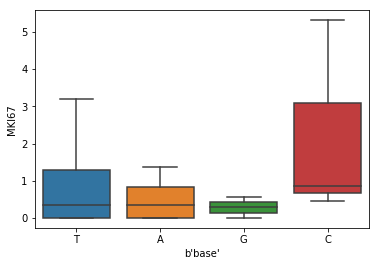

In [137]:
sns.boxplot(data=varExpressionDf,x=b'base',y='MKI67',showfliers=False)

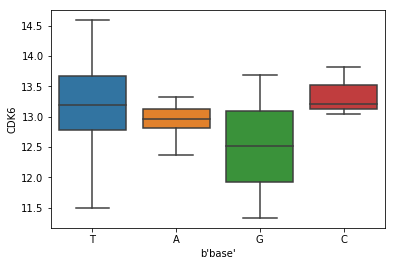

In [128]:
sns.boxplot(data=varExpressionDf,x=b'base',y='CDK6',showfliers=False)

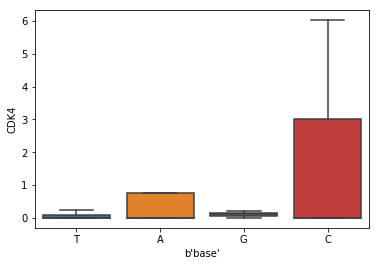

In [129]:
sns.boxplot(data=varExpressionDf,x=b'base',y='CDK4',showfliers=False)

# scratch

### BRAF V600 mutation are measured and extracted from many different data layers

as show in the following figure

In [ ]:
query_study_id='SRP067759'
hitSrrDf=technical_meta_data_df[technical_meta_data_df.Study==query_study_id]

In [ ]:
hitSrrDf.head()

In [ ]:
myChrPosDf_I=myChrPosDf.set_index([b'Run_db','Run_digits'])

In [ ]:
m=myChrPosDf_I.index.isin(hitSrrDf.index)

In [ ]:
#m.mean()

In [ ]:
myChrPosDf_Hit=myChrPosDf[m]

In [ ]:
v600eSite=140753336#-1 

In [ ]:
#myChrPosDf_Hit[myChrPosDf_Hit.Pos==v600eSite]#[b'base'].value_counts()

In [ ]:
g=myChrPosDf_Hit[myChrPosDf_Hit.Pos==v600eSite].groupby(['Pos',b'base'])

In [ ]:
g.size()

In [ ]:
myChrPosDf_Hit.set_index(['Pos',b'base'])['ReadDepth'].unstack()

In [ ]:
altBaseDf=myChrPosDf[(myChrPosDf['Pos']==queryPosition)&(myChrPosDf['AltBase'])]

In [ ]:
altBaseDf.head()

In [ ]:
altBaseDf=altBaseDf.set_index([b'Run_db','Run_digits'])

### load in technical meta data

For more information about the aliases used in the follow meta data:

https://www.ncbi.nlm.nih.gov/books/NBK56913/



In [ ]:
sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

In [ ]:
technical_meta_data_df.shape

#### use the techinical meta data table to backtrack which omic layers the study is from

In [ ]:
technical_meta_data_df.head()

In [ ]:
technical_meta_data_df['Run']=technical_meta_data_df.index

technical_meta_data_df=technical_meta_data_df.set_index(['Run_db','Run_digits'])#.index.isin(altBaseDf.index)

In [ ]:
hitSrrDf=technical_meta_data_df[technical_meta_data_df.index.isin(altBaseDf.index)]

In [ ]:
VC=hitSrrDf.LibraryStrategy.value_counts()
ax=VC[VC>0].to_frame('Data layers').plot.bar()
ax.set_ylabel('# of sequencing runs')

# compare with CDK4 and CDK6 expression

* Given that: BRAFV600 mutation is associated proliferation. 
* We should observe stronger proliferation signal: And in this example we use CDK4 and CDK6 expression level as read out for proliferaiton: 
http://cancerdiscovery.aacrjournals.org/content/6/4/353

### memory map the expression data matrix

In [ ]:

def loadDf(fname,mmap_mode='r'):
    with open(fname+'.index.txt') as f:
        myIndex=map(lambda s:s.replace("\n",""), f.readlines())
    with open(fname+'.columns.txt') as f:
        myColumns=map(lambda s:s.replace("\n",""), f.readlines())
    tmpMatrix=np.load(fname+".npy",mmap_mode=mmap_mode)
    tmpDf=pd.DataFrame(tmpMatrix,index=myIndex,columns=myColumns)
    tmpDf.columns.name='Run'
    return tmpDf

expression_metric='TPM'
#change this to where the matrix is located on your computer
baseDir='/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/'
data_matrix_dir_fmt=baseDir+'/allSRAmatrix.realign.v9.base.{feature}.gene.symbol'.format(feature=expression_metric)
rnaseqDf=loadDf(data_matrix_dir_fmt)

### dimension of expression dataframe 

In [ ]:
rnaseqDf.shape

### head of expression dataframe

In [ ]:
rnaseqDf.head()

### subset the Giustacchini et al. 2017 study

In [ ]:
query_study_id='SRP067759'
hitSrrDf=technical_meta_data_df[technical_meta_data_df.Study==query_study_id]

In [ ]:
is_alt=hitSrrDf.index.isin(altBaseDf.index)
hitSrrDf.loc[is_alt,'altBase']=True
hitSrrDf.loc[~is_alt,'altBase']=False

In [ ]:
hitSrrDf.altBase.value_counts()

In [ ]:
metaDataMappingSDir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'
bio_metaDf=pd.read_pickle(metaDataMappingSDir)

In [ ]:

%time bio_metaDf_sub=bio_metaDf.loc[hitSrrDf['Sample'].unique()]

In [ ]:
bio_metaDf_sub_re=bio_metaDf_sub.reset_index()#.groupby(['level_1',0]).size().sort_values().tail(n=50)

In [ ]:
bio_metaDf_sub_re.columns=['SRS','Attrib','Text']

In [ ]:
tmpSampleS=hitSrrDf.groupby('Sample')['altBase'].any()

In [ ]:

bio_metaDf_sub_re['Alternative']=tmpSampleS[bio_metaDf_sub_re['SRS']].values

In [ ]:
#hitSrrDf

In [ ]:
g=bio_metaDf_sub_re[bio_metaDf_sub_re.Attrib=='tumor stage'].groupby('Text')
print(g.mean(),)

In [ ]:
g.size()

# scratch

In [ ]:
%%time 
A=rnaseqDf.loc[:,rnaseqDf.columns.isin(hitSrrDf['Run'].values)]

#### randomly sample a background

In [ ]:
n=A.shape[1]
backgroundSrrs=rnaseqDf.columns.to_series().sample(n=n).values
B=rnaseqDf.loc[:,backgroundSrrs]

#### query the CDK4 and CDK6 expression levels 

In [ ]:
inGenes=['CDK4','CDK6']

In [ ]:
caseLabel='With BRAF V600 mutation\n n='+str(n)
ctrlLabel='CTRL\n n='+str(n)
exprDf=np.log2(pd.concat([ A.loc[inGenes],B.loc[inGenes]],axis=1,keys=[caseLabel,ctrlLabel],names=['Status'])+1)
exprDf.index.name='Gene'

In [ ]:
from scipy import stats
import seaborn as sns
yLabel='log2(TPM+1)'
inDf=exprDf.T.stack().reset_index(name=yLabel)
inPlotDf=inDf[inDf[yLabel]>0.5]### an arbitrary threshold to throw away the tail at 0
sns.factorplot(data=inPlotDf,col='Gene',x='Status',y=yLabel,showfliers=False,kind='box',sharey=False,size=3)


yay, p-values are less than 0.05 (if you follow the p-values cult)

In [ ]:
for inGene in inGenes:
    tmpDf=inPlotDf[inPlotDf['Gene']==inGene]
    tmp_A=tmpDf[tmpDf['Status']==caseLabel][yLabel]
    tmp_B=tmpDf[tmpDf['Status']==ctrlLabel][yLabel]
    t,p=stats.ttest_ind(tmp_A,tmp_B)
    print (inGene,p)

### What are the labels extracted from annotations of sequencing runs with BRAF V600 mutations


### load in biological meta data

For more information about bio_metaDf columns:

Sample: https://www.ncbi.nlm.nih.gov/books/NBK56913/

attribute: https://www.ncbi.nlm.nih.gov/biosample/docs/attributes/

NCIT_Eng, NCIT_ID: https://ncit.nci.nih.gov/

NLM_CUI: https://www.nlm.nih.gov/research/umls/new_users/online_learning/Meta_005.html

The NLP tool used for mapping freetexts to terms is called metamap:
https://metamap.nlm.nih.gov/

In [ ]:
metaDataMappingSDir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP//input/allAttrib.v5.csv.NCI.prefilter.pyc'
bio_metaDf=pd.read_pickle(metaDataMappingSDir)

Millions of biological annotations have NLP key words extracted with high number of unique terms, suggesting that public data deposited in SRA has both high volumne and diversity in experimental conditions. 

In [ ]:
print '# of unique biological sample annotations with terms extracted:',bio_metaDf['srs'].nunique()

In [ ]:
print '# of unique biomedical terms:',bio_metaDf['NCI'].nunique()

#### slice out the biological meta data associated with BRAF V600 mutations

In [ ]:
hitMetaDf=bio_metaDf[bio_metaDf.srs.isin(hitSrrDf['Sample'].unique())]

### the attributes associated with the meta data

picking the restricted attributes you key to slice on usually improve relevancy of labels

In [ ]:
hitMetaDf['attrib'].value_counts().head(n=10)

### most commmon terms from annotations of sequencing runs with BRAF V600 mutations

It is unsurprising that "Melnaoma" is in one of the top terms. 

In [ ]:
selected_attribs=['source name','TITLE','tissue','phenotype']
ax=hitMetaDf[hitMetaDf['attrib'].isin(selected_attribs)]['NciEng'].value_counts().head(n=30).plot.bar()#.drop_duplicates()
ax.set_ylabel('# of sequencing runs')

### use ontology to identify relevant terms

take only tissue and disease relevant terms by taking the children terms of the term "Tissue"

In [ ]:
import NCITerminology as NCIT

In [ ]:
onto=NCIT.NCITerminology()

In [ ]:
### subset the edges to traverse only part_of, is_a and disease edges
is_a_rels=onto.relToEng[onto.relToEng.str.lower().str.contains('(?:has[\w_]+_parent)|(?:disease)')].index.tolist()+['is_a','R82']
onto.setCellOntoEdgeSubset(is_a_rels)

In [ ]:
onto.cleanedIdS[onto.cleanedIdS.str.contains('^Tissue$')]

In [ ]:
childrenTerms=(onto.childrenTermsOf('C12801'))

In [ ]:
ax=hitMetaDf[hitMetaDf['attrib'].isin(selected_attribs)&hitMetaDf['NCI'].isin(childrenTerms)]['NciEng'].value_counts().head(n=30).plot.bar()#.drop_duplicates()
ax.set_ylabel('# of sequencing runs')

### What are the experiments with BRAF V600 mutation that are extracted from Bone?

In [ ]:
myHitTechnicalDf=technical_meta_data_df[technical_meta_data_df['Sample'].isin(hitMetaDf[(hitMetaDf['NciEng']=='Bone')]['srs'].values)]

### the top experiment is from this study

In [ ]:
myHitTechnicalDf['Study'].value_counts().head(n=2)

It is rather unexpected that the term "Bone" is the most freqeunt term. 
And when I reference SRA db: 
https://www.ncbi.nlm.nih.gov/sra/?term=SRP067759
It is showing this single cell leukemia RNAseq study study: https://www.nature.com/articles/nm.4336
, where luekemia begins in bone marrow.

The BRAF V600 mutation is not mentioned in their study,
but there are multiple evidence to support the confidence of this mutation:

1. Many of their allelic read counts usually have the A->T mutation, which is the more common transition for oncogenic transformation.
2. High read depth for alternative allele (T) across across many experiments.
3. High base quality for the alternative allele (T)



In [ ]:
queryPosDf=myChrPosDf[(myChrPosDf['Pos']==queryPosition)].set_index(['Run_db','Run_digits'])

In [ ]:
queryPosDf['log10_ReadDepth']=np.log10(queryPosDf['ReadDepth'])

In [ ]:
subHitDf=queryPosDf.loc[queryPosDf.index.isin(myHitTechnicalDf.index)]

a lot of the RNAseq samples have alternative allele, T, detected

In [ ]:
ax=subHitDf.groupby(['base']).size().sort_values(ascending=False).plot.bar()
ax.set_ylabel('# of sequencing runs with more than 5 reads at base')

the alternative allele T has high read depth over all the leukemia RNAseq samples

In [ ]:
sns.boxplot(data=queryPosDf.loc[queryPosDf.index.isin(myHitTechnicalDf.index)].dropna(),x='base',y='log10_ReadDepth')

the alternative allele T often have high base quality over all the leukemia RNAseq samples

In [ ]:
sns.boxplot(data=queryPosDf.loc[queryPosDf.index.isin(myHitTechnicalDf.index)].dropna(),x='base',y='AverageBaseQuality')

### tally them mory usage 

For performance reason, we try to keep as much data in memory as possible. 
Metadata is small, genomic data is big. 
Metadata is stored in a single pickle.

Molecular data can't be loaded in memory therefore, we keep the molecular data on disk and load them in when needed.
1. SNP data is stored in chunks of HDF5 object. We ignored the last 5 digits in the genomic position and use the prefix as the chunk name. 
2. Expression data is stored as a single numpy matrix, which offer memory mapping 

In [ ]:
print 'memory used by technical meta dataframe(GB):',float(technical_meta_data_df.memory_usage().sum())/10**9

In [ ]:
print 'memory used by biological meta dataframe(GB):',float(bio_metaDf.memory_usage().sum())/10**9

### size of disk usage

1. snp data takes roughly 200G of the disk space once decompressed
2. expression matrix takes roughly 20G


In [ ]:
!ls -laht /cellar/users/btsui/Data/SRA/snp/Homo_sapiens_snp_pos/  | head -n 1

In [ ]:
!ls -lah /cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/allSRAmatrix.realign.v9.base.TPM.gene.symbol.npy

# more examples

#### High resolution mouse developmental hierachy map
[Link](https://github.com/brianyiktaktsui/Skymap/blob/master/jupyter-notebooks/clean_notebooks/TemporalQuery_V4_all_clean.ipynb
)

Aggregating many studies (node) to form a smooth mouse developmental hierachy map. 

Each componenet represent a tissue. Each node represent a particular study at a particular time unit. The color is base on the developmental time extracted from experimental annotation using regex. The node size represent the # of sequencing runs in that particulr time point and study. Each edge represent a differentiate-to or part-of relationship.
![alt text](./Figures/heirachy_time.png "Logo Title Text 1")
And you can easily overlay gene expression level on top of it. As an example, Tp53 expression is known to be tightly regulated in development. Let's look at the dynamic of Tp53 expression over time and spatial locations in the following plot.
![alt_text](./Figures/heirachy_Trp53.png "tp53")

#### simple data slicing and hypothesis testing
[Link](https://github.com/brianyiktaktsui/Skymap/blob/master/DataSlicingExample.ipynb)

[Check here for more example notebooks](https://github.com/brianyiktaktsui/Skymap/tree/master/jupyter-notebooks
)

The code for the pipelines is here:
https://github.com/brianyiktaktsui/Skymap/tree/master/code


# In long: 
## Motivation: Pooling processed data from multiple studies is time-consuming: 
When I first started in bioinformatic couple years ago, I spent much of my time doing two things: 1.) cleaning omic data matrices, e.g. mapping between gene IDs (hgnc, enseml, ucsc, etc.) for processed data matrices, trying all sort of different bioinformatics pipelines that yield basically the same results, investigating what is the exact unit being counted over when pulling data from public database, etc.  2.) cleaning metadata annotation, which usually involves extracting and aliasing the labels to the exact same categories. 

This question came to my mind: Can we merge and reduce the peta-bytes worth of public omic data in a table while capturing the commonly used information that can fit into your hard drive (<500 GB), like firehose for TCGA data? 

## Solution: An automated pipeline to generate a single data matrix that does simple counting for each specie and omic layer 
What I am offering in here is a metadata table and a single data matrix for each omic layer that encapsulate majority of the public data out there. I do believe that “Science started with counting” (from “Cancer: Emperor of all malady” by Siddhartha Mukherjee), and thus I offer raw counts for all the features: 1. ) the  base resolution ACGT counts for over 200k experiments among NCBI curated SNPs, where read depth and allelic fraction are usually the main drivers for SNP calling. We also offer an expression matrix, where most counts at both transcript and gene resolution, where most normalization can be done post-hoc. 
The metadata table consists of controlled vocabulary (NCI Terminology) from free text annotations of each experiment. I used the NLM metamap engine for this purpose. The nice thing is that the UMLS ecosystem from NLM allow the IDs (Concept Unique Identifiers) to be mapped onto different ontology hierarchy to relate the terms. 
The pipeline in here is trying to suit the needs of the common use cases. In another word, most pipelines out there are more like sport cars, having custom flavors for a specific group of drivers. What I am trying to create is more like a train system, aiming to suit most needs. Unfortunately, if you have more specific requirements, what I am offering is probably not going to work. 

## Why Skymap while there are so many groups out there also trying to unify the public data
To the best of my knowledge, Skymap is the first that offer both the unified omic data and cleaned metadata. The other important aspect is that the process of data extraction is fully automated, so it is supposed to be scalable.  
Data format and coding style:
I tried to keep the code and parameters to be lean and self-explanatory for your reference, but most of the scripts I wrote are far from the industrial standard. 
The storage is in python pandas pickle format. The ecosystem in python appears to be much better at handling large dataset while offering intuitive coding interfaces. For now, Skymap is geared towards ML/data science folks who are hungry for the vast amount of data and ain’t afraid of coding.

Skymap is still in Beta V0.0. [Please feel free to leave comments](https://www.synapse.org/#!Synapse:syn11415602/discussion/default) and suggestions!!! We would love to hear feedbacks from you.
## Acknowledgement


Please considering citing if you are using Skymap. (doi:10.7303/syn11415602)

Acknowledgement: We want to thank for the advice and resources from Dr. Hannah Carter (my PI), Dr. Jill Mesirov,Dr. Trey Ideker and Shamin Mollah. We also want to thank Dr. Ruben Arbagayen, Dr. Nate Lewis for their suggestion. 
The method will soon be posted in bioarchive. Also, we want to thank the Sage Bio Network for hosting the data. We also thank to thank the NCBI for holding all the published raw reads at  [Sequnece Read Archive](https://www.ncbi.nlm.nih.gov/sra). 
Grant money that make this work possible: NIH DP5OD017937,GM103504

Term of use: Use Skymap however you want. Just dont sue me, I have no money. 

For why I named it Skymap, I forgot.

In [ ]:
VC=bio_metaDf.NciEng.value_counts()

In [ ]:
VC[VC.index.str.contains('Asthma',case=False)]

In [ ]:
#bio_metaDf.head()

In [ ]:
technical_meta_data_df.shape

In [ ]:
public_meta_df=technical_meta_data_df[(technical_meta_data_df['proj_accession_Visibility']=='public')]

In [ ]:
#public_meta_df

In [ ]:
bio_metaDf[(bio_metaDf.NciEng=="Asthma")&(bio_metaDf.srs.isin(public_meta_df.Sample))]